<a href="https://colab.research.google.com/github/MajidNoorani/action-identification-with-Electroencephalogram-Signal/blob/main/Action_Identification_on_Electroencephalogram_Signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import packages

In [1]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import math
import json
import numpy as np
import keras
from keras import layers
import tensorflow as tf
from sklearn import preprocessing, model_selection
import random

## Data
Download the [data](https://www.kaggle.com/datasets/berkeley-biosense/synchronized-brainwave-dataset?resource=download) and put it in a directory

and then extract the csv data from it

In [2]:
# extracting eeg-data into data folder
with zipfile.ZipFile('/content/eeg-data.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data')

In [ ]:
df = pd.read_csv('/content/data/eeg-data.csv')
df.head()

,Unnamed: 0,id,indra_time,browser_latency,reading_time,attention_esense,meditation_esense,eeg_power,raw_values,signal_quality,createdAt,updatedAt,label
0,3730,12,2015-05-09 23:13:42.281,1461,2015-05-09 16:13:40.954,0,0,"[944412.0, 111373.0, 52404.0, 28390.0, 3237.0,...","[-203.0, -202.0, -196.0, -185.0, -163.0, -137....",200,2015-05-09 23:13:39.550,2015-05-09 23:13:39.549+00,unlabeled
1,3732,12,2015-05-09 23:13:43.186,1461,2015-05-09 16:13:41.964,0,0,"[1793049.0, 89551.0, 3896.0, 21727.0, 9301.0, ...","[104.0, 134.0, 128.0, 121.0, 145.0, 151.0, 123...",200,2015-05-09 23:13:40.559,2015-05-09 23:13:40.559+00,unlabeled
2,3734,12,2015-05-09 23:13:44.392,1461,2015-05-09 16:13:42.950,0,0,"[400192.0, 640624.0, 153087.0, 69733.0, 98854....","[2002.0, 2047.0, 2047.0, 2047.0, 2047.0, 2047....",200,2015-05-09 23:13:41.549,2015-05-09 23:13:41.549+00,unlabeled
3,3735,12,2015-05-09 23:13:45.297,1461,2015-05-09 16:13:43.935,0,0,"[681192.0, 138630.0, 67891.0, 26459.0, 592240....","[1287.0, 1241.0, 1196.0, 1155.0, 1113.0, 1072....",200,2015-05-09 23:13:42.532,2015-05-09 23:13:42.532+00,unlabeled
4,3737,12,2015-05-09 23:13:46.201,1460,2015-05-09 16:13:44.936,0,0,"[268406.0, 197772.0, 190654.0, 266433.0, 91683...","[1905.0, 1836.0, 1770.0, 1707.0, 1645.0, 1587....",200,2015-05-09 23:13:43.532,2015-05-09 23:13:43.532+00,unlabeled


In [ ]:
# keeping the rows with proper labels
unlabeled_eeg = df[df["label"] == "unlabeled"]
df = df.loc[df["label"] != "unlabeled"]
df = df.loc[df["label"] != "everyone paired"]

In [ ]:
df.columns

Index(['Unnamed: 0', 'id', 'indra_time', 'browser_latency', 'reading_time',
       'attention_esense', 'meditation_esense', 'eeg_power', 'raw_values',
       'signal_quality', 'createdAt', 'updatedAt', 'label'],
      dtype='object')

In [ ]:
# drop unwanted columns
df.drop(
    [
        "indra_time",
        "Unnamed: 0",
        "browser_latency",
        "reading_time",
        "attention_esense",
        "meditation_esense",
        "updatedAt",
        "createdAt",
    ],
    axis=1,
    inplace=True,
)

df.reset_index(drop=True, inplace=True)
df.head()

,id,eeg_power,raw_values,signal_quality,label
0,7,"[56887.0, 45471.0, 20074.0, 5359.0, 22594.0, 7...","[99.0, 96.0, 91.0, 89.0, 91.0, 89.0, 87.0, 93....",0,blinkInstruction
1,5,"[11626.0, 60301.0, 5805.0, 15729.0, 4448.0, 33...","[23.0, 40.0, 64.0, 89.0, 86.0, 33.0, -14.0, -1...",0,blinkInstruction
2,1,"[15777.0, 33461.0, 21385.0, 44193.0, 11741.0, ...","[41.0, 26.0, 16.0, 20.0, 34.0, 51.0, 56.0, 55....",0,blinkInstruction
3,13,"[311822.0, 44739.0, 19000.0, 19100.0, 2650.0, ...","[208.0, 198.0, 122.0, 84.0, 161.0, 249.0, 216....",0,blinkInstruction
4,4,"[687393.0, 10289.0, 2942.0, 9874.0, 1059.0, 29...","[129.0, 133.0, 114.0, 105.0, 101.0, 109.0, 99....",0,blinkInstruction


We only keep the signals which the values in signal_quality column is less than 128.

In this data, signal_quality = 0 shows the best calibration

In [ ]:
QUALITY_THRESHOLD = 128
df = df.loc[df["signal_quality"] < QUALITY_THRESHOLD]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9954 entries, 0 to 9958
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              9954 non-null   int64 
 1   eeg_power       9954 non-null   object
 2   raw_values      9954 non-null   object
 3   signal_quality  9954 non-null   int64 
 4   label           9954 non-null   object
dtypes: int64(2), object(3)
memory usage: 466.6+ KB


In [ ]:
type(df['raw_values'].values[0])

str

In [ ]:

def convert_string_data_to_values(value_string):
    # since the values in raw_values column are string we need to convert them
    str_list = json.loads(value_string)
    return str_list

df["raw_values"] = df["raw_values"].apply(convert_string_data_to_values)
df.head()

,id,eeg_power,raw_values,signal_quality,label
0,7,"[56887.0, 45471.0, 20074.0, 5359.0, 22594.0, 7...","[99.0, 96.0, 91.0, 89.0, 91.0, 89.0, 87.0, 93....",0,blinkInstruction
1,5,"[11626.0, 60301.0, 5805.0, 15729.0, 4448.0, 33...","[23.0, 40.0, 64.0, 89.0, 86.0, 33.0, -14.0, -1...",0,blinkInstruction
2,1,"[15777.0, 33461.0, 21385.0, 44193.0, 11741.0, ...","[41.0, 26.0, 16.0, 20.0, 34.0, 51.0, 56.0, 55....",0,blinkInstruction
3,13,"[311822.0, 44739.0, 19000.0, 19100.0, 2650.0, ...","[208.0, 198.0, 122.0, 84.0, 161.0, 249.0, 216....",0,blinkInstruction
4,4,"[687393.0, 10289.0, 2942.0, 9874.0, 1059.0, 29...","[129.0, 133.0, 114.0, 105.0, 101.0, 109.0, 99....",0,blinkInstruction


In [ ]:
type(df['raw_values'].values[0][0])

float

### plotting a sample

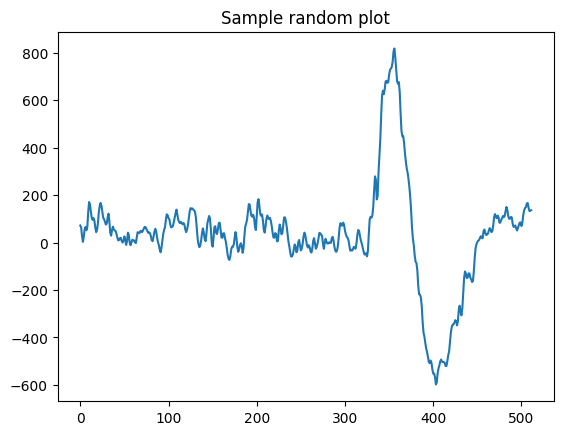

In [ ]:
def view_eeg_plot(idx):
    data = df.loc[idx, "raw_values"]
    plt.plot(data)
    plt.title(f"Sample random plot")
    plt.show()

view_eeg_plot(7)

In [ ]:
print(df['label'].unique())
print(df['label'].nunique())

array(['blinkInstruction', 'blink1', 'blink2', 'blink3', 'blink4',
       'blink5', 'relaxInstruction', 'relax', 'mathInstruction', 'math1',
       'math2', 'math3', 'math4', 'math5', 'math6', 'math7', 'math8',
       'math9', 'math10', 'math11', 'math12', 'musicInstruction', 'music',
       'videoInstruction', 'video-ver1', 'thinkOfItemsInstruction-ver1',
       'thinkOfItems-ver1', 'colorInstruction1', 'colorInstruction2',
       'readyRound1', 'colorRound1-1', 'colorRound1-2', 'colorRound1-3',
       'colorRound1-4', 'colorRound1-5', 'colorRound1-6', 'readyRound2',
       'colorRound2-1', 'colorRound2-2', 'colorRound2-3', 'colorRound2-4',
       'colorRound2-5', 'colorRound2-6', 'readyRound3', 'colorRound3-1',
       'colorRound3-2', 'colorRound3-3', 'colorRound3-4', 'colorRound3-5',
       'colorRound3-6', 'readyRound4', 'colorRound4-1', 'colorRound4-2',
       'colorRound4-3', 'colorRound4-4', 'colorRound4-5', 'colorRound4-6',
       'readyRound5', 'colorRound5-1', 'colorRound5-2'

In [ ]:
def change_labels(label):
  ref = ['blinkInstruction', 'blink', 'mathInstruction', 'math', 'thinkOfItemsInstruction', 'thinkOfItems', 'videoInstruction', 'video', 'colorRound1', 'colorRound2', 'colorRound3', 'colorRound4', 'colorRound5' , 'colorInstruction', 'readyRound']
  for word in ref:
    if word in label:
      return word
  else:
    return label


In [ ]:
df['label'] = df['label'].apply(change_labels)

In [ ]:
print(df['label'].unique())
print(df['label'].nunique())

['blinkInstruction' 'blink' 'relaxInstruction' 'relax' 'mathInstruction'
 'math' 'musicInstruction' 'music' 'videoInstruction' 'video'
 'thinkOfItemsInstruction' 'thinkOfItems' 'colorInstruction' 'readyRound'
 'colorRound1' 'colorRound2' 'colorRound3' 'colorRound4' 'colorRound5']
19


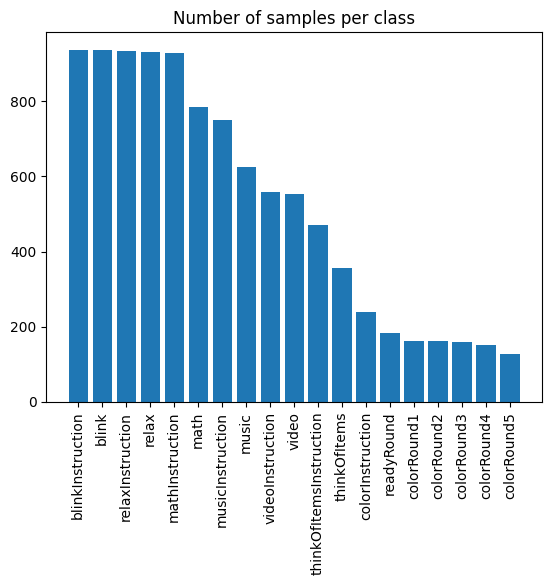

In [ ]:
plt.bar(df['label'].unique(), df["label"].value_counts())
plt.xticks(rotation=90)
plt.title("Number of samples per class")
plt.show()

In [ ]:
le = preprocessing.LabelEncoder()  # Generates a look-up table
le.fit(df["label"])
df["label"] = le.transform(df["label"])

### Scaling

In [ ]:
scaler = preprocessing.MinMaxScaler()

series_list = [
    scaler.fit_transform(np.asarray(i).reshape(-1, 1)) for i in df["raw_values"]
]

In [ ]:
labels_list = [i for i in df["label"]]

In [ ]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    series_list, labels_list, test_size=0.15, random_state=42, shuffle=True
)

print(
    f"Length of x_train : {len(x_train)}\nLength of x_test : {len(x_test)}\nLength of y_train : {len(y_train)}\nLength of y_test : {len(y_test)}"
)

x_train = np.asarray(x_train).astype(np.float32).reshape(-1, 512, 1)
y_train = np.asarray(y_train).astype(np.float32).reshape(-1, 1)
y_train = keras.utils.to_categorical(y_train)

x_test = np.asarray(x_test).astype(np.float32).reshape(-1, 512, 1)
y_test = np.asarray(y_test).astype(np.float32).reshape(-1, 1)
y_test = keras.utils.to_categorical(y_test)

Length of x_train : 8460
Length of x_test : 1494
Length of y_train : 8460
Length of y_test : 1494


## Setup and Config

In [ ]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = BATCH_SIZE * 2

## conver data to tf.data.dataset format and batching

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

NameError: name 'SHUFFLE_BUFFER_SIZE' is not defined

# Class weights

Since the data is imbalanced we need to specify the weight of each class to

prevent it from being fitted on the classes with higher number of samples


In [ ]:
vals_dict = {}
for i in eeg["label"]:
    if i in vals_dict.keys():
        vals_dict[i] += 1
    else:
        vals_dict[i] = 1
total = sum(vals_dict.values())

# Formula used - Naive method where
# weight = 1 - (no. of samples present / total no. of samples)
# So more the samples, lower the weight

weight_dict = {k: (1 - (v / total)) for k, v in vals_dict.items()}
print(weight_dict)

# History plot

In [ ]:
def plot_history_metrics(history: keras.callbacks.History):
    total_plots = len(history.history)
    cols = total_plots // 2

    rows = math.ceil(total_plots / cols)

    plt.figure(figsize=(15, 10))
    for i, (key, value) in enumerate(history.history.items()):
        plt.subplot(rows, cols, i+1)
        plt.plot(range(len(value)), value)
        plt.title(str(key))
    plt.show()

# Model

In [ ]:
def create_model():
    input_layer = keras.Input(shape=(512, 1))

    x = layers.Conv1D(
        filters=32, kernel_size=3, strides=2, activation="relu", padding="same"
    )(input_layer)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=64, kernel_size=3, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=128, kernel_size=5, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=256, kernel_size=5, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=512, kernel_size=7, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=1024,
        kernel_size=7,
        strides=2,
        activation="relu",
        padding="same",
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dropout(0.2)(x)

    x = layers.Flatten()(x)

    x = layers.Dense(4096, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(
        2048, activation="relu", kernel_regularizer=keras.regularizers.L2()
    )(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(
        1024, activation="relu", kernel_regularizer=keras.regularizers.L2()
    )(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(
        128, activation="relu", kernel_regularizer=keras.regularizers.L2()
    )(x)
    output_layer = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs=input_layer, outputs=output_layer)